# Automated Image Captioning - Flickr8K dataset

In [88]:
import pandas as pd
import cv2,tensorflow
import matplotlib.pyplot as plt
import json
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.preprocessing import image,sequence
from PIL import Image
import pickle
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
import tensorflow
tensorflow.config.run_functions_eagerly(True)

In [2]:
def readTextFile(file):
    with open(file,'r') as f:
        data = f.read().split('\n')
    return data

### 1. Data Collection 

In [ ]:
captions_path = './Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
captions = open(captions_path).read().split('\n')

In [ ]:
captions

In [ ]:
captions = captions[:-1]

In [ ]:
caption_dict = {}

In [ ]:
 #mapping of img id to captions
for x in range(len(captions)):
    cap = captions[x].split('\t')
    first,second= cap[0],cap[1]
    img_name = first.split('.')[0]
    if img_name not in caption_dict:
        caption_dict[img_name] = []
    caption_dict[img_name].append(second)

In [ ]:
caption_dict["1235685934_be89b231fb"]

In [ ]:
len(caption_dict)

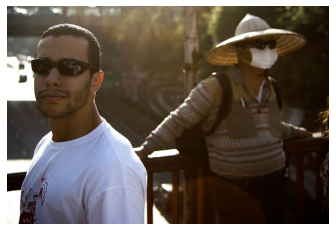

In [3]:
img_path = "./Flickr_Data/Images"
img = cv2.imread(img_path + "/1235685934_be89b231fb.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

### 2. Data Cleaning

Stemming and lemmatization, stopword removal are not relevant for this task, because we aim to generate text and that should be grammatically correct

In [ ]:
import re
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]"," ",sentence) #removing everything except characters
    sentence = sentence.split() #to avoid unnecessary spaces
    sentence = " ".join(sentence)
    return sentence

In [ ]:
for img,caption_list in caption_dict.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [ ]:
caption_dict["1235685934_be89b231fb"]

In [ ]:
with open("cleaned_text.txt",'w') as f:
    f.write(str(caption_dict)) #to prevent recomputation of cleaned text

### 3. Building Vocabulary

In [3]:
with open("cleaned_text.txt",'r') as f:
    caption_dict = f.read()
caption_dict = caption_dict.replace("'","\"") #since the keys are in single quotes but json needs two
caption_dict = json.loads(caption_dict) #so that we obtain a dictionary

In [6]:
print(caption_dict["1235685934_be89b231fb"])

['a man in sunglasses on an overpass', 'a man looking at the camera with another man wearing a mask', 'a man wearing sunglasses is standing next to a person who is wearing a hat and breathing mask', 'the man is wearing a white shirt and sunglasses', 'there are two men with sunglasses one of which is wearing a hat and a backpack']


In [4]:
vocab = set()
for key in caption_dict.keys():
    [vocab.update(sentence.split()) for sentence in caption_dict[key]]

In [5]:
len(vocab) #number of unique words

8441

In [6]:
#remove words with very less frequency(less than threshold)
threshold = 10
total_words = []
for key in caption_dict.keys():
    [total_words.append(word) for caption in caption_dict[key] for word in caption.split() ]

In [7]:
import collections
counter = collections.Counter(total_words)
#print(counter)

In [8]:
sorted_freq = sorted(counter.items(),key = lambda x: x[1],reverse = True)

In [9]:
sorted_freq

[('a', 62995),
 ('in', 18987),
 ('the', 18420),
 ('on', 10746),
 ('is', 9345),
 ('and', 8863),
 ('dog', 8138),
 ('with', 7765),
 ('man', 7275),
 ('of', 6723),
 ('two', 5643),
 ('white', 3959),
 ('black', 3848),
 ('boy', 3581),
 ('are', 3505),
 ('woman', 3403),
 ('girl', 3328),
 ('to', 3176),
 ('wearing', 3062),
 ('at', 2916),
 ('people', 2887),
 ('water', 2790),
 ('red', 2691),
 ('young', 2630),
 ('brown', 2578),
 ('an', 2432),
 ('his', 2357),
 ('blue', 2279),
 ('dogs', 2125),
 ('running', 2073),
 ('through', 2032),
 ('playing', 2008),
 ('while', 1968),
 ('shirt', 1962),
 ('down', 1843),
 ('standing', 1789),
 ('ball', 1783),
 ('little', 1768),
 ('grass', 1622),
 ('snow', 1547),
 ('child', 1545),
 ('person', 1542),
 ('jumping', 1473),
 ('over', 1415),
 ('three', 1389),
 ('front', 1386),
 ('sitting', 1368),
 ('holding', 1324),
 ('up', 1302),
 ('field', 1283),
 ('small', 1278),
 ('by', 1249),
 ('large', 1237),
 ('green', 1234),
 ('one', 1223),
 ('group', 1218),
 ('yellow', 1217),
 ('her',

In [10]:
final_vocab = []
[final_vocab.append(word[0]) for word in sorted_freq if word[1] > threshold]
print(len(final_vocab)) #contains only the words that have frequency greater than threshold

1850


In [13]:
final_vocab[-2]

'bridesmaids'

### 4. Preparing the Train and Test data

In [14]:
train_data = readTextFile("./Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
train_data = train_data[:-1] #last character is an empty space
train_data = [name.split('.jpg')[0] for name in train_data]

In [20]:
len(train_data)

6000

In [15]:
# add start and stop words to know when to stop in the rnn
def add_eos(data):
    train_descriptions = {}
    for i in range(len(data)):
        caps = caption_dict[data[i]]
        mod = []
        for cap in caps:
            mod.append("<s> " + cap + " <e>")
        train_descriptions[data[i]]= mod
    return train_descriptions

In [16]:
test_data = readTextFile("./Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")
test_data = test_data[:-1]
test_data = [name.split('.jpg')[0] for name in test_data]

In [19]:
len(test_data)

1000

In [ ]:
caption_dict['3222055946_45f7293bb2']

In [21]:
train_desc = add_eos(train_data)
test_desc = add_eos(test_data)

In [24]:
len(train_desc['2950393735_9969c4ec59']) #5 captions

5

### 5. Image to Vectors - Transfer Learning and Preprocessing

In [25]:
# Pretrained weights from ResNet50 [Comparison can be done with VGG, InceptionNet etc]
from tensorflow.keras.applications import ResNet50
model = ResNet50(weights = "imagenet",input_shape = (224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [21]:
model_new = Model(model.input, model.layers[-2].output) #2048 feature vector for image

In [22]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis = 0) #reshape into a 4D tensor so that it can be accepted by ResNet
    img = tensorflow.keras.applications.resnet.preprocess_input(img) #carries out the preprocessing required by ResNet
    return img

In [23]:
def encode_img(img):
    img = preprocess_img(img)
    img_vec = model_new.predict(img)
    return img_vec.reshape((-1,))

In [29]:
IMG_PATH = "./Flickr_Data/Images"

In [24]:

def img_convert(imgNames):
    encoding = {}
    for i in imgNames:
        img = IMG_PATH + '/' + i + '.jpg'
        encoding[i] = encode_img(img)
    return encoding

In [ ]:
encoding_train = img_convert(train_data)
with open("encoding_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [ ]:
encoding_test = img_convert(test_data)
with open("encoding_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

In [ ]:
len(train_input)

In [26]:
# Load the train images features from disk
with open("encoding_train_features.pkl", "rb") as encoded_pickle:
    encoding_train = pickle.load(encoded_pickle)

In [27]:
# Load the test images features from disk
with open("encoding_test_features.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

In [33]:
encoding_train['2950393735_9969c4ec59'].shape

(2048,)

In [34]:
len(encoding_train)

6000

### 6. Caption Preprocessing

In [35]:
word_to_idx = {}
idx_to_word = {}
for i,word in enumerate(final_vocab):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [42]:
len(idx_to_word)

1850

In [40]:
idx_to_word[4]

'on'

In [41]:
word_to_idx['on']

4

In [43]:
idx_to_word[1851] = '<s>'
word_to_idx['<s>'] = 1851
idx_to_word[1852] = '<e>'
word_to_idx['<e>'] = 1852

In [44]:
max_len = 0
for key in caption_dict.keys():
    for cap in caption_dict[key]:
        max_len = max(max_len,len(cap.split()))

In [45]:
max_len

36

In [71]:
encoding_train['2513260012_03d33305cf']

array([0.3470795 , 0.51159084, 0.08728848, ..., 1.1897296 , 0.04043847,
       0.1527106 ], dtype=float32)

### Data Loader(generator) 

In [86]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,num_photos):
    x1,x2,y = [],[],[] #x1--> image, x2-->sequence, y--> output
    n = 0
    while True:
        for key,cap_list in train_descriptions.items():
            n +=1
            photo = encoding_train[key]
            for cap in cap_list:
                seq = [word_to_idx[word] for word in cap.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    xi = sequence.pad_sequences([xi],maxlen = max_len, value = 0,padding = 'post')[0]
                    yi = to_categorical([yi],num_classes = vocab_size)[0]
                    x1.append(photo)
                    x2.append(xi)
                    y.append(yi)
            if n== num_photos:
                yield ([np.array(x1),np.array(x2)],np.array(y))
                x1,x2,y = [],[],[]
                n = 0

### 7. Words to Vectors - Transfer Learning on captions using GloVe embeddings

In [47]:
#load the embeddings- 6B,50D and create a mapping
word_vectors = {}
with open('glove.6B.50d.txt', encoding = 'utf-8') as f:
    for line in f.readlines():
        emb = line.split()
        word_vectors[emb[0]] = np.asarray(emb[1:],dtype = 'float')

In [48]:
def get_embedding_matrix():
    emb_dim = 50 #since we are using  50 D glove embeddings
    matrix = np.zeros((len(word_to_idx)+1,emb_dim))
    for word,idx in word_to_idx.items():
        vector = word_vectors.get(word)
        if vector is not None:
            matrix[idx] = vector
    return matrix

In [49]:
embedding_matrix = get_embedding_matrix()

In [52]:
embedding_matrix[1] # it will be 0s for <s> and <e>

array([ 0.21705 ,  0.46515 , -0.46757 ,  0.10082 ,  1.0135  ,  0.74845 ,
       -0.53104 , -0.26256 ,  0.16812 ,  0.13182 , -0.24909 , -0.44185 ,
       -0.21739 ,  0.51004 ,  0.13448 , -0.43141 , -0.03123 ,  0.20674 ,
       -0.78138 , -0.20148 , -0.097401,  0.16088 , -0.61836 , -0.18504 ,
       -0.12461 , -2.2526  , -0.22321 ,  0.5043  ,  0.32257 ,  0.15313 ,
        3.9636  , -0.71365 , -0.67012 ,  0.28388 ,  0.21738 ,  0.14433 ,
        0.25926 ,  0.23434 ,  0.4274  , -0.44451 ,  0.13813 ,  0.36973 ,
       -0.64289 ,  0.024142, -0.039315, -0.26037 ,  0.12017 , -0.043782,
        0.41013 ,  0.1796  ])

In [53]:
embedding_matrix.shape

(1853, 50)

In [54]:
vocab_size = 1853 # +1 for 0

### 8. Model Architecture

In [73]:
#for the images
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256, activation = 'relu')(inp_img1)

In [74]:
#for the captions
input_captions = Input(shape = (max_len,))
inp_cap1 = Embedding(input_dim = vocab_size,output_dim = 50, mask_zero = True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [75]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation = 'relu')(decoder1)
outputs = Dense(vocab_size,activation = 'softmax')(decoder2)

In [76]:
#combined model
model2 = Model(inputs = [input_img_features,input_captions],outputs = outputs)

In [77]:
model2.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 36)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 36, 50)       92650       input_5[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_4[0][0]                    
_______________________________________________________________________________________

In [78]:
model2.layers[2].set_weights([embedding_matrix])
model2.layers[2].trainable = False

In [79]:
model2.compile(loss= 'categorical_crossentropy',optimizer = 'adam')

#### Training the Model

In [80]:
epochs = 10
num_pics_per_batch = 3
steps = len(train_desc)//num_pics_per_batch

In [ ]:
type(train_input)

In [89]:
#def train():
for i in range(epochs):
    #try:
    generator = data_generator(train_desc,encoding_train,word_to_idx,max_len,num_pics_per_batch)
    model2.fit_generator(generator,epochs = 1,steps_per_epoch = steps, verbose=1)
    model2.save('./model_weights/model_'+str(i)+'.h5' )
    #except:
        #print(i)

C:\Users\Ambika Sadhu\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3349: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2000/2000 [==============================] - 1507s 753ms/step - loss: 3.8846


OSError: Unable to create file (unable to open file: name = './model_weights/model_0.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)

### 9. Making Predictions

In [67]:
def predict_caption(photo):
    in_text = "<s>"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen= max_len,padding = 'post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #greedy sampling--> selecting words with max prob
        word = idx_to_word[ypred]
        in_text += ' '+word
        
        if word == '<e>':
            break
        final_caption = in_text.split()[1:-1] #ignoring the first and last tokens
        final_caption = ' '.join(final_caption)
        
        return final_caption
        